# ERA5 Land examples

These examples demonstrate the use of ERA5 Land data from the Copernicus service. It uses two locations related to RISKADAPT Pilots: Lake Polyfytos Bridge in Greece and Cattinara Hospital in Italy. The demonstration studies one month (August) from year 1980 to 2019 and calculates monthly maxima from the provided hourly data. It shows how total precipitation with hourly data can be accumulated into 24-hour total precipitation for each hour that is more usable for hydrological studies. For wind speed, the u and v components of wind are interpolated to a given locations and transformed to wind speed.

The provided script `era5land_download.py` can be used to download the data for one location and month over years 1980-2019.

In [1]:
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

from glob import glob

DATA = os.path.expanduser('~/DATA/RISKADAPT/')

locations = {
    'Lake Polyfytos Bridge': [21.973889, 40.232778],
    'Cattinara Hospital Trieste': [13.826012, 45.634376],
}

## Extreme precipitation at Lake Polyfytos

First we study extreme precipitation near Lake Polyfytos Bridge that is the subject of study in RISKADAPT Pilot 1. Data for August preciptation for years 1980-2019 have been downloaded with the utility `era5land_download.py`. 

In [2]:
file = DATA+'era5_land_1980-2019_August_tp_Polyfytos.nc'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:     (time: 1280, step: 24, latitude: 2, longitude: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1980-07-31 1980-08-01 ... 2019-08-31
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     float64 ...
  * latitude    (latitude) float64 40.3 40.2
  * longitude   (longitude) float64 21.9 22.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    tp          (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-08T09:01 GRIB to CDM+CF via cfgrib-0.9.1...

The variable `tp` has total precipitation cumulated hourly, separately for each day. The unit is meters. We interpolate to given location and adjust the coordinates for easier processing.

In [3]:
lon, lat = locations['Lake Polyfytos Bridge']
tp = ds['tp'].interp(longitude=lon, latitude=lat)

tp = (tp.stack(z=('time', 'step')).
       swap_dims({'z': 'valid_time'}).
       drop(['z', 'number', 'surface', 'time', 'step']).
       rename({'valid_time': 'time'}))
tp

<xarray.DataArray 'tp' (time: 30720)>
array([        nan,         nan,         nan, ..., 1.29357e-05,
       1.29357e-05,         nan])
Coordinates:
  * time       (time) datetime64[ns] 1980-07-31T01:00:00 ... 2019-09-01
    longitude  float64 21.97
    latitude   float64 40.23
Attributes: (12/30)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      4
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_shortName:                           tp
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown

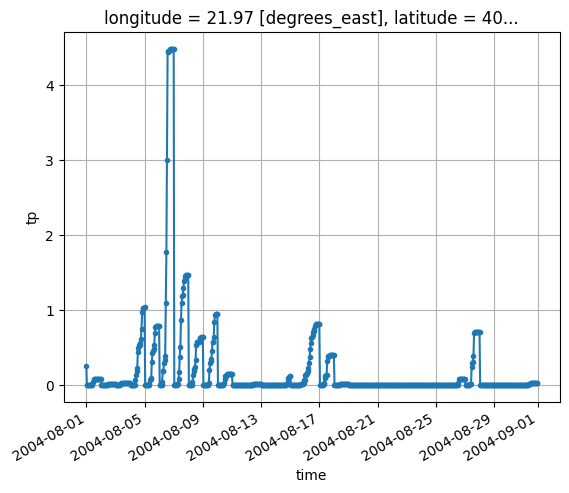

In [4]:
(tp.where(tp['time.year']==2004)*1000).plot(marker='.')
plt.grid()
plt.show()

Sum the daily values for the selected month for each year and then take 24 hour differences to get `tp24`, which is the total precipitation for each previous 24 hours. Transform m to mm.

In [5]:
tp24 = tp.groupby(tp['time.year']).cumsum() * 1000
tp24.name = 'tp24'

def tp24fun(ds):
       time1 = ds.time[ds.time >= ds.time[0] + np.timedelta64(24, 'h')]
       time2 = time1 - np.timedelta64(24, 'h')
       out = xr.full_like(ds, fill_value=np.nan)
       out.loc[dict(time=time1)] = (ds.sel(time=time1).values -
                                    ds.sel(time=time2).values)
       return out

tp24 = tp24.groupby(tp24['time.year']).map(tp24fun)
tp24

<xarray.DataArray 'tp24' (time: 30720)>
array([    nan,     nan,     nan, ..., 0.17789, 0.18867, 0.18651])
Coordinates:
  * time       (time) datetime64[ns] 1980-07-31T01:00:00 ... 2019-09-01
    longitude  float64 21.97
    latitude   float64 40.23

[]

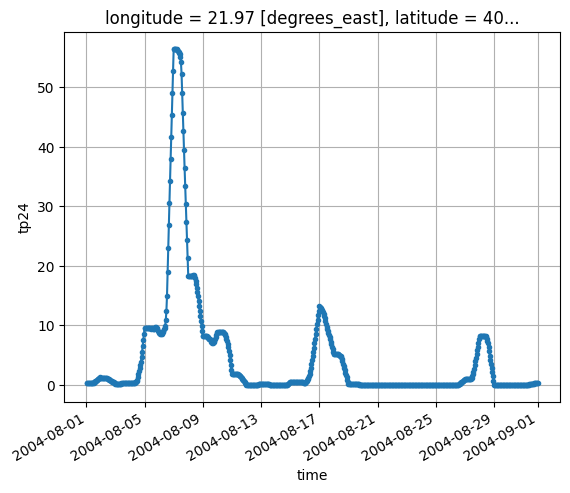

In [6]:
tp24.where(tp24['time.year']==2004).plot(marker='.')
plt.grid()
plt.plot()

And then we can calculate the maximum 24 hour precipitation for each year for the selected month.

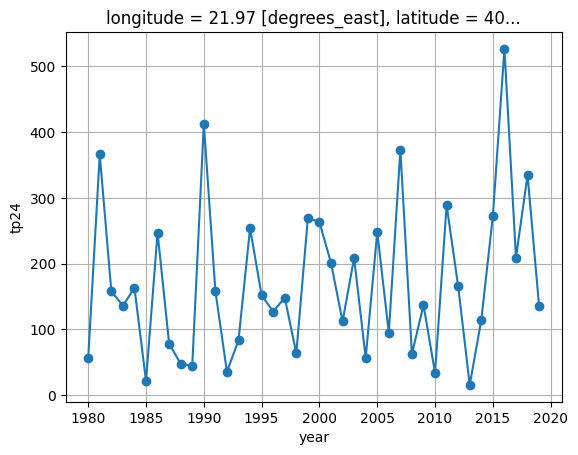

In [7]:
tp24.groupby('time.year').max().plot(marker='o')
plt.grid()
plt.show()

Now we could proceed to extreme value analysis.

## Maximum wind speed near Cattinara Hospital

The next example calculates maximum 10 meter wind speed interpolated to the location of Cattinara hospital in Trieste, Italy. We study the August maximum 10 meter wind speed. ERA5 stores the wind as u and v components. First, we need to calculate 10 meter wind speed from those and do similar coordinate manipulations as for the tp above.

In [8]:
file = DATA+'era5_land_1980-2019_August_uv10_Trieste.nc'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:     (time: 1280, step: 24, latitude: 2, longitude: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1980-07-31 1980-08-01 ... 2019-08-31
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     float64 ...
  * latitude    (latitude) float64 45.7 45.6
  * longitude   (longitude) float64 13.8 13.9
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    u10         (time, step, latitude, longitude) float32 ...
    v10         (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-09T14:26 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
lon, lat = locations['Cattinara Hospital Trieste']
ds['ws10'] = np.sqrt(np.square(ds['u10']) + np.square(ds['v10']))
ds['ws10'].attrs = ds['u10'].attrs.copy()                                         
ds['ws10'].attrs['long_name'] = '10 metre wind speed'
ws10 = ds['ws10'].interp(longitude=lon, latitude=lat).astype(np.float32)

ws10 = (ws10.stack(z=('time', 'step')).
       swap_dims({'z': 'valid_time'}).
       drop(['z', 'number', 'surface', 'time', 'step']).
       rename({'valid_time': 'time'}))
ws10

<xarray.DataArray 'ws10' (time: 30720)>
array([    nan,     nan,     nan, ..., 1.88802, 1.86969,     nan],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-07-31T01:00:00 ... 2019-09-01
    longitude  float64 13.83
    latitude   float64 45.63
Attributes: (12/30)
    GRIB_paramId:                             165
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      4
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           10u
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre wind speed
    units:                                    m s**-1
    standard_name:                            unknown

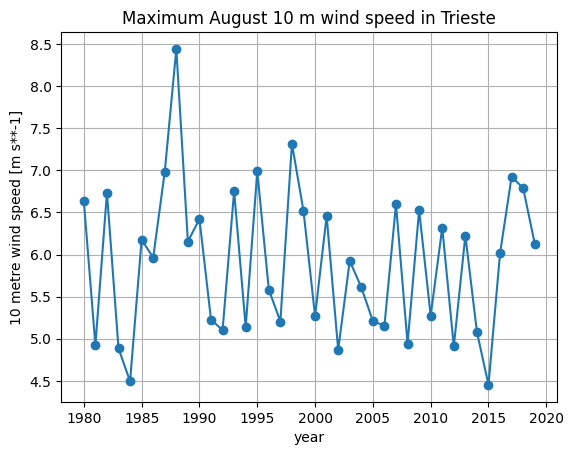

In [10]:
ws10.groupby('time.year').max().plot(marker='o')
plt.title('Maximum August 10 m wind speed in Trieste')
plt.grid()
plt.show()